In [31]:
from pathlib import Path
from typing import List, Optional, Union

import dotenv
from IPython.display import Image, display
from langchain.tools.retriever import create_retriever_tool
from langchain_community.utilities.dalle_image_generator import DallEAPIWrapper
from langchain_core.documents import Document
from langchain_core.messages import AIMessage, SystemMessage
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_text_splitters import MarkdownHeaderTextSplitter
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.types import Command, interrupt
from openai import OpenAI
from pydantic import Field
from typing_extensions import Annotated, TypedDict

dotenv.load_dotenv()

True

### RAG

##### Documents

In [32]:
SHEETS_PATH = Path("data/karty-postaci/")
sheets = SHEETS_PATH.glob("*.md")

split_document = []
for sheet in sheets:
    with open(sheet, "r") as f:
        raw_markdown = f.read()
        # sheets_raw.append(f.read())

    document_id = sheet.stem

    document = Document(page_content=raw_markdown, metadata={"document_id": document_id})

    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
        ("####", "Header 4"),
    ]
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on, strip_headers=False)

    splits = markdown_splitter.split_text(document.page_content)
    for chunk_id, split in enumerate(splits):
        chunk_document = Document(
            page_content=split.page_content,
            metadata={
                **document.metadata,
                **split.metadata,
                "chunk_id": chunk_id,
            },
        )
        split_document.append(chunk_document)

split_document

[Document(metadata={'document_id': 'Anioł', 'Header 1': 'TWORZENIE ANIOŁA', 'chunk_id': 0}, page_content='# TWORZENIE ANIOŁA  \nAby stworzyć swojego anioła, wybierz imię, wygląd, cechy, ruchy oraz sprzęt.'),
 Document(metadata={'document_id': 'Anioł', 'Header 1': 'TWORZENIE ANIOŁA', 'Header 2': 'OPIS POSTACI', 'chunk_id': 1}, page_content='## OPIS POSTACI  \nLeżysz w piachu Świata Apokalipsy, z flakami na wierzchu. O czyją pomoc się modlisz? Bogów? Dawno odeszli.\nTwoich przyjaciół? To same dupki, inaczej nie leżałbyś teraz tutaj.\nA może chcesz do mamusi? Jest kochana, ale nie wpakuje ci flaków z powrotem do brzucha. Modlisz się o kogoś, obojętnie kogo, z igłą, nitką\ni sześciopakiem morfiny. A kiedy wreszcie się zjawi, zdaje się być aniołem.'),
 Document(metadata={'document_id': 'Anioł', 'Header 1': 'TWORZENIE ANIOŁA', 'Header 2': 'IMIĘ', 'chunk_id': 2}, page_content='## IMIĘ  \nWybierz jedno z poniższych imion:  \n- Dou\n- Bon\n- Abe\n- Boo\n- T\n- Kal\n- Bai\n- Char\n- Jav\n- Ruth\

##### Chroma DB

In [33]:
from langchain_community.vectorstores import Chroma
from langchain_openai.embeddings import OpenAIEmbeddings

vectorstore = Chroma.from_documents(split_document, OpenAIEmbeddings())

vectorstore

##### Retriever

In [34]:
main_retriever = vectorstore.as_retriever(search_kwargs={"k": 10}, search_type="similarity")

main_retriever_tool = create_retriever_tool(
    main_retriever,
    "retrieve_character_sheet",
    "Search and return information about how to create given character for tabletop RPG game 'Świat Apokalipsy'.",
)

description_retriever = vectorstore.as_retriever(
    search_kwargs={"k": 1, "filter": {"Header 2": "OPIS POSTACI"}}, search_type="mmr"
)

description_retriever_tool = create_retriever_tool(
    description_retriever,
    "describe_character_sheet",
    "Search and return information about characters description for tabletop RPG game 'Świat Apokalipsy'.",
)

## Model, tools, graph state

In [35]:
from typing import Dict, List, Optional, Union

from pydantic import Field
from typing_extensions import Annotated, TypedDict


class Answer(TypedDict):
    """Answer to a question"""

    answer: Annotated[str, ..., "The answer to the question"]


class Question(TypedDict):
    """Question to ask the user"""

    question: Annotated[str, ..., "The question to ask the user"]
    guidance: Annotated[str, ..., "Guidance to help the user answer the question"]
    answer: Annotated[Optional[str], ...]


class Questions(TypedDict):
    """List of questions to ask the user"""

    questions: List[Question] = Field(description="The questions to ask the user", min_length=3)


class CharactersSummary(TypedDict):
    """Summary of the characters in the story"""

    appearance: Annotated[str, ..., "Description of the character's appearance"]
    description: Annotated[str, ..., "Description of the character"]


class Move(TypedDict):
    """Moves of the character"""

    name: Annotated[str, ..., "The name of the move"]
    description: Annotated[str, ..., "The description of the move"]


class Stuff(TypedDict):
    """Stuff (Sprzęt) of the character"""

    name: Annotated[str, ..., "The name of the stuff"]
    additional_info: Annotated[str, ..., "The additional information about the stuff"]
    isRemovable: Annotated[bool, False, "Whether the stuff can be removed"]
    isWeapon: Annotated[bool, False, "Whether the stuff is a weapon"]
    options: Optional[List[Dict[str, str]]] = None


class CharacterMoves(TypedDict):
    """Character moves"""

    basic_moves: Union[str, List[Move]] = Field(
        description="The basic moves of the character",
        default="Dostajesz wszystkie ruchy podstawowe",
    )
    class_moves: list[Move] = Field(description="The moves of the character's class")


class CharacterTraits(TypedDict):
    """Character traits"""

    name: Annotated[str, ..., "The name of the trait"]
    modifier: Annotated[str, ..., "The modifier of the trait. ex. -1, 0, +1, +2"]


class CharacterSpecs(TypedDict):
    """Specifications of the character"""

    name: Annotated[str, ..., "The name of the character"]
    traits: Annotated[list[CharacterTraits], ..., "The set of characteristics. Zestaw cech postaci"]
    stuffs: Annotated[list[Stuff], ..., "The stuffs of the character"]


# State - has messages from MessagesState
class GraphState(MessagesState):
    questions: Questions
    image_url: Optional[str]
    summary: CharactersSummary
    character_class: Optional[Annotated[str, ..., "The class of the character"]]
    document_sheet: Optional[Document]
    character_specs: Optional[CharacterSpecs]
    moves: Annotated[CharacterMoves, ..., "The moves of the character"]


model = ChatOpenAI(model="gpt-4o-mini")
model_with_json_questions_output = model.with_structured_output(Questions)
model_with_json_summary_output = model.with_structured_output(CharactersSummary)

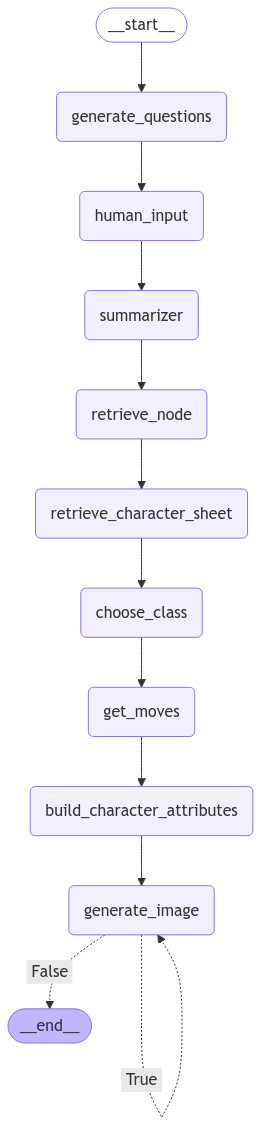

In [65]:
# Node
def generate_questions(state: GraphState):
    sys_msg = SystemMessage("""
You are helpful assistant to generate 3 helpful questions with a short guidance about how to answer them based on given information.
Those questions should be helpful to later generate a character for the tabletop RPG game called "Świat Apokalipsy".
Question should be more specific than general and should help to fill character's sheet like class, skills, items.

You will receive a 4 block of information:
1. basic information which will contain name of the character, age and other basic information.
    example: Moja postać ma na imię Max, ma 25 lat, jest wysokim, szczupłym mężczyzną o ciemnych włosach i niebieskich oczach.
2. history of the character which will contain information about the past and skills of the character gained during the past.
    example: Max urodził się w małej wiosce, gdzie jego rodzina prowadziła gospodarstwo rolne. W wieku 18 lat opuścił rodzinny dom i wyruszył w świat, aby zdobyć nowe doświadczenia. Podczas swoich podróży nauczył się walczyć i przetrwać w trudnych warunkach.
3. Character's traits which will contain information about the character's personality and other traits.
    example: Max jest odważny, lecz nieufny wobec obcych. Jest lojalny wobec swoich przyjaciół i gotów poświęcić się dla nich. Często działa impulsywnie, co prowadzi go do niebezpiecznych sytuacji.
4. Game's world information which will contain information about the world where the game takes place.
    example: Świat postapokaliptycznego przedmieścia Warszawy, gdzie przetrwali unikają stolicy.

Example of questions:
1. Co sprawiło, że Twoja postać przetrwała apokalipsę?
    Pomyśl o umiejętnościach, szczęściu lub okolicznościach, które pozwoliłyby Twojej postaci przetrwać.
2. Jakie wydarzenie z przeszłości Twojej postaci miało największy wpływ na jej obecną postawę?
    Może to być trauma, triumf lub inna sytuacja, która ukształtowała Twoją postać.
3. Kogo Twoja postać straciła podczas apokalipsy i jak to wpłynęło na jej życie?
    Zastanów się nad relacjami i więzami, które zostały zerwane.

Your output should be in Polish language and contain exactly 3 questions.
""")

    questions = model_with_json_questions_output.invoke([sys_msg] + state["messages"])
    return {"messages": [], "questions": questions}


# Node
def human_input(state: GraphState):
    human_message = interrupt("human_input")
    for i, answer in enumerate(human_message["answers"]):
        answer_t = answer["answer"]
        print(state["questions"]["questions"])
        state["questions"]["questions"][i]["answer"] = answer_t

    print(state["questions"])

    return {"messages": [], "questions": state["questions"]}


# Node
def summarizer(state: GraphState):
    sys_msg = SystemMessage(
        """You are helpful assistant to generate a summary of the character based on the given information.

        Your task is to generate a summary of the character based on the information provided by the user in the same language as the input.

        Your output should contain the following information:

        Wygląd (appearance) - basic information about the character's appearance, short but detailed description. 1-2 sentences.
        Opis (description) -  description of the character. May contain extremely short background and basic traits. 5 sentences at most.
        """
    )

    last_human_message = state["messages"][0]

    answers = ""
    for question in state["questions"]["questions"]:
        answers += f"{question['answer']}\n"

    character_info = last_human_message.content + "\n" + answers

    summary = model_with_json_summary_output.invoke([sys_msg] + [character_info])

    text_summary = f"{summary['appearance']}\n{summary['description']}"
    ai_message = AIMessage(text_summary)
    state["messages"].append(ai_message)
    return {"messages": state["messages"], "summary": summary}


# Node
def retrieve_node(state: GraphState):
    messages = state["messages"]
    last_message = messages[-1]

    model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    prompt = PromptTemplate(
        template="""
        You are an assistant for retrieving information about the character's description for tabletop RPG game 'Świat Apokalipsy'.
        Use the following pieces of information to retrieve the character's class description.
        information about the character to which the description should be related: \n\n {context} \n\n
        """,
        input_variables=["context"],
    )

    model_with_tools = model.bind_tools([description_retriever_tool])
    chain = prompt | model_with_tools

    response = chain.invoke({"context": last_message})

    docs = description_retriever.get_relevant_documents(last_message.content)
    print(f"{docs=}")
    return {"messages": [response], "document_sheet": docs[0]}


# Node
def choose_class(state: GraphState):
    document = state["document_sheet"]
    class_name = document.metadata["document_id"]

    print(f"Class is {class_name}")
    return {"character_class": class_name}


def get_moves(state: GraphState):
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    prompt = PromptTemplate(
        template="""
        You are an assistant for selecting moves for the given character's description for tabletop RPG game 'Świat Apokalipsy'.
        You will get a characters description and class sheet.
        Your goal is to retrieve RUCHY of class (including descriptions) and RUCHY PODSTAWOWE from class sheet, and choose the best options for the character according to the description of each category.
        
        When extracting RUCHY of the class include the description of each move.
        When extracting RUCHY PODSTAWOWE answer "Dostajesz wszystkie ruchy podstawowe".
        
        Description: \n\n {description} \n\n
        Class sheet: \n\n {class_sheet} \n\n
        """,
        input_variables=["description", "class_sheet"],
    )

    model_wth_structured_output = model.with_structured_output(CharacterMoves)
    chain = prompt | model_wth_structured_output

    character_class = state["character_class"]
    character_sheet_path = SHEETS_PATH / f"{character_class}.md"
    description = f"{state['summary']['appearance']}\n{state['summary']['description']}"
    class_sheet = character_sheet_path.read_text()
    response = chain.invoke({"description": description, "class_sheet": class_sheet})
    print(f"Character specs: {response}")
    return {"messages": state["messages"], "moves": response}


# Node
def build_character_attributes(state: GraphState):
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    prompt = PromptTemplate(
        template="""
        You are an assistant for creating a character for tabletop RPG game 'Świat Apokalipsy'.
        You will get a characters description, class sheet and moves.
        Analyze the information.
        Your goal is to retrieve CECHY and SPRZĘT, and choose the best options for the character according to the description of each category.
                
        Description: \n\n {description} \n\n
        Moves: \n\n {moves} \n\n
        Class sheet: \n\n {class_sheet} \n\n
        """,
        input_variables=["description", "class_sheet", "moves"],
    )

    model_wth_structured_output = model.with_structured_output(CharacterSpecs)
    character_class = state["character_class"]
    character_sheet_path = SHEETS_PATH / f"{character_class}.md"

    description = f"{state['summary']['appearance']}\n {state['summary']['description']}"
    class_sheet = character_sheet_path.read_text()

    chain = prompt | model_wth_structured_output
    response = chain.invoke(
        {"description": description, "class_sheet": class_sheet, "moves": state["moves"]}
    )
    print(f"Character specs: {response}")
    return {"messages": state["messages"], "character_specs": response}


# Node
def generate_image(state: GraphState):
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
    appearance = state["summary"]["appearance"]
    description = state["summary"]["description"]
    prompt = PromptTemplate(
        template="""
        Using the provided appearance and description of a character, compose a detailed and vivid description suitable for DALL-E to generate an image.
        The image should depict a fully visible character—not just the face—in a post-apocalyptic world.
        Include intricate details about the character's clothing, equipment, surroundings, and pose to create an immersive and visually striking scene.
        Image cannot contain any text or logos.
        Character should be sad and determined, with a sense of loss and hope.
        The scene should feature cinematic lighting, gritty textures, dramatic shadows, post-apocalyptic themes, a warm and dusty color palette, high-definition quality, realistic details, and bold composition --ar 16:9.

        Appearance: \n\n {appearance} \n\n
        Description: \n\n {description} \n\n

        """,
        input_variables=["appearance", "description"],
    )
    # Your output shold not be longer than 500 characters.
    content = (
        f"""
        Using the provided appearance and description of a character, create a detailed and vivid image of the character.
        The image should depict a fully visible character—not just the face—in a post-apocalyptic world.
        Include intricate details about the character's clothing, equipment, surroundings, and pose to create an immersive and visually striking scene.
        Image cannot contain any text or logos.
        Character should be sad and determined, with a sense of loss and hope.
        The scene should feature cinematic lighting, gritty textures, dramatic shadows, post-apocalyptic themes, a warm and dusty color palette, high-definition quality, realistic details, and bold composition --ar 16:9.

        Appearance: \n\n {appearance} \n\n
        Description: \n\n {description} \n\n

        Your output shold not be longer than 500 characters.
        """
    )

    chain = prompt | model
    image_url = DallEAPIWrapper(model="dall-e-3").run(content)
    return {"messages": state["messages"], "image_url": image_url}


# Edge
def human_interrupt_new_image(state: GraphState):
    human_message = interrupt("human_input")
    return human_message["is_new_image"].lower() == "yes"


workflow = StateGraph(GraphState)

workflow.add_node("generate_questions", generate_questions)
workflow.add_node("human_input", human_input)
workflow.add_node("summarizer", summarizer)
workflow.add_node("retrieve_node", retrieve_node)
workflow.add_node("generate_image", generate_image)

description_retrieve_character_sheet = ToolNode([description_retriever_tool])
workflow.add_node("retrieve_character_sheet", description_retrieve_character_sheet)

workflow.add_node("choose_class", choose_class)
workflow.add_node("build_character_attributes", build_character_attributes)
workflow.add_node("get_moves", get_moves)

workflow.add_edge(START, "generate_questions")
workflow.add_edge("generate_questions", "human_input")
workflow.add_edge("human_input", "summarizer")
workflow.add_edge("summarizer", "retrieve_node")
workflow.add_edge("retrieve_node", "retrieve_character_sheet")
workflow.add_edge("retrieve_character_sheet", "choose_class")
workflow.add_edge("choose_class", "get_moves")
workflow.add_edge("get_moves", "build_character_attributes")
workflow.add_edge("build_character_attributes", "generate_image")

# workflow.add_edge("generate_image", END)
workflow.add_conditional_edges(
    "generate_image",
    human_interrupt_new_image,
    {
        True: "generate_image",
        False: END,
    },
)

checkpointer = MemorySaver()

graph = workflow.compile(checkpointer=checkpointer)


display(Image(graph.get_graph().draw_mermaid_png()))

In [66]:
config = {"configurable": {"thread_id": "21"}}

joseph_mechanik = {
    "messages": "Joseph jest 35 letnim mężczyzną o szerokiej sylwetce bez lewego oka i długimi włosami, nosi opaskę na lewym oku.\n\nZa życia był udanym mechanikiem i prowadził dużą sieć serwisów samochodowych.\n\nJoseph jest bardzo szczerym i wesołym, zawsze znajdzie moment na żart.\n\nOstatnia wojna nuklearna zmasakrowała cały świat, ale cudem ominęła Otwock, który leży przy Warszawie."
}

ania_lekarz = {
    "messages": "Ania jest 25 letnią kobietą o krótkich blond włosach i zielonych oczach, nosi okulary.\n\nZa życia była lekarką i prowadziła małą przychodnię w Otwocku.\n\nAnia jest bardzo cicha i skryta, ale zawsze gotowa pomóc innym.\n\nOstatnia wojna"
}

olek_xd = {
    "messages": "Olek jest 22 letnim mężczyzną o srednich jasnych blond włosach\n\nBył inżynierem i informatykiem, pracował na uczelni i w małych firmach\n\nCzasem robi się bardzo agresywny, lubi czarny humor\n\nOstatnia wojna nuklearna zmasakrowała cały świat, ale cudem ominęła Otwock, który leży przy Warszawie."
}

resp = graph.invoke(
    joseph_mechanik,
    config=config,
)

for m in resp["messages"]:
    m.pretty_print()

print()
print(resp["questions"])

================================ Human Message =================================

Joseph jest 35 letnim mężczyzną o szerokiej sylwetce bez lewego oka i długimi włosami, nosi opaskę na lewym oku.

Za życia był udanym mechanikiem i prowadził dużą sieć serwisów samochodowych.

Joseph jest bardzo szczerym i wesołym, zawsze znajdzie moment na żart.

Ostatnia wojna nuklearna zmasakrowała cały świat, ale cudem ominęła Otwock, który leży przy Warszawie.

{'questions': [{'question': 'Jakie umiejętności mechaniczne Joseph wykorzystał, aby przetrwać w zniszczonym świecie?', 'guidance': 'Pomyśl o konkretnych umiejętnościach związanych z mechaniką, które mogą być przydatne w apokaliptycznym otoczeniu, np. naprawa pojazdów czy tworzenie improwizowanych narzędzi.', 'answer': ''}, {'question': 'Jak Joseph radzi sobie z utratą lewego oka i jak to wpływa na jego interakcje z innymi?', 'guidance': 'Zastanów się, jak jego niepełnosprawność może wpływać na jego codzienne życie, relacje z innymi oraz na jeg

In [ ]:
joseph_answers = {
    "answers": [
        {
            "answer": "Joseph przetrwał dzięki swoim umiejętnościom naprawy czegokolwiek, co tylko może się zepsuć."
        },
        {"answer": "Czysto biznesowe."},
        {"answer": "Młotek, taśma i klej. Najważniejsze rzeczy do naprawy."},
    ],
}

ania_answers = {
    "answers": [
        {"answer": "Ania wykorzystuje swoje umiejętności chirurgiczne by pomagać znajomym."},
        {
            "answer": "Ania jest zimna i szybka w swoich decyzjach, które często ratują życia i losy."
        },
        {"answer": "Wygoda i zabezpieczenie siebie."},
    ],
}

olek_answers = {
    "answers": [
        {"answer": "Znajomość technologii i możliwość jej reprodukcji."},
        {"answer": "Żadne, już taki byłem."},
        {"answer": "Wszystko."},
    ]
}

resp = graph.invoke(
    Command(resume=joseph_answers),
    config=config,
)

for m in resp["messages"]:
    m.pretty_print()

[{'question': 'Jakie umiejętności mechaniczne Joseph wykorzystał, aby przetrwać w zniszczonym świecie?', 'guidance': 'Pomyśl o konkretnych umiejętnościach związanych z mechaniką, które mogą być przydatne w apokaliptycznym otoczeniu, np. naprawa pojazdów czy tworzenie improwizowanych narzędzi.', 'answer': ''}, {'question': 'Jak Joseph radzi sobie z utratą lewego oka i jak to wpływa na jego interakcje z innymi?', 'guidance': 'Zastanów się, jak jego niepełnosprawność może wpływać na jego codzienne życie, relacje z innymi oraz na jego postrzeganie samego siebie.', 'answer': ''}, {'question': "Jak poczucie humoru Joseph'a pomaga mu i innym w trudnych czasach?", 'guidance': 'Rozważ, w jaki sposób jego wesołość i żarty mogą wpływać na morale grupy lub na jego własne przetrwanie w trudnych sytuacjach.', 'answer': ''}]
[{'question': 'Jakie umiejętności mechaniczne Joseph wykorzystał, aby przetrwać w zniszczonym świecie?', 'guidance': 'Pomyśl o konkretnych umiejętnościach związanych z mechaniką,

In [48]:
print(resp["character_class"])
print(resp["character_specs"])
print(resp["image_url"])
display(Image(url=resp["image_url"]))

Egzekutor
{'name': 'Joseph', 'traits': [{'name': 'Spokój', 'modifier': '+1'}, {'name': 'Hart', 'modifier': '+2'}, {'name': 'Urok', 'modifier': '−1'}, {'name': 'Spryt', 'modifier': '+1'}, {'name': 'Dziw', 'modifier': '0'}], 'stuffs': [{'name': 'karabin snajperski', 'additional_info': '(3-rany, daleki, hi-tech)', 'isWeapon': True}, {'name': 'strzelba', 'additional_info': '(3-rany, bliski, przeładowanie, jatka)', 'isWeapon': True}, {'name': 'pistolet maszynowy', 'additional_info': '(2-rany, bliski, automatyczny, głośny)', 'isWeapon': True}, {'name': 'pancerz warty 2-pancerza', 'additional_info': '(ty ustalasz szczegóły)', 'isRemovable': False}, {'name': 'zestaw narzędzi', 'additional_info': 'młotek, taśma, klej', 'isRemovable': False}]}
https://oaidalleapiprodscus.blob.core.windows.net/private/org-K0W2aXzkOgcAfm4FEf4f44cd/user-qzbMqpJ0zqfRq7YWKp8dfHsD/img-lez8dL3BP0nbKDXOjIu78rmv.png?st=2025-01-19T22%3A14%3A29Z&se=2025-01-20T00%3A14%3A29Z&sp=r&sv=2024-08-04&sr=b&rscd=inline&rsct=image/png

In [ ]:
display(Image(url=graph.invoke(Command(resume={"is_new_image": "yes"}), config=config)["image_url"]))